# Abstract

The following notebook is an investigation into the word2vec algorithm which relies on neural networks to map words onto a 2 dimensional vector space in accordance with the Distributional Hypothesis. 

The Distributional Hypothesis states that words that appear in similar context have similar meanings.

The following notebook extracts words from various textbooks and uses several common NLP techniques to clean data and map words into a vector space where similarity can be inferred from distance on this space. This notebook was developed by following the following tutorial: https://www.youtube.com/watch?v=pY9EwZ02sXU&t=1862s 

In [60]:
#Goal: Create word vectors from a textbook dataset 
# and analyze their semantic simlarities
#Step 0 - Import dependencies
from __future__ import absolute_import, division, print_function
#for word encoding
import codecs
#regex
import glob
#concurrency
import multiprocessing
#dealing with operating system, like reading afile
import os
#pretty printing, human readable
import pprint
#regex
import re
#NLTK
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
#lemmatize or convert word to stem/root words
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
#word2vec
import gensim.models.word2vec as w2v
#dimensionality reduction - Siraj Raval has a video on how to visualize datasets
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#3d plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
#enable interative zooming/panning with 3d plot
import mpld3
#parse pandas as pd
import pandas as pd
#visualization
import seaborn as sns
#wikipedia api
import wikipedia
#d3 could be a useful library
#k means clustering
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics
# dataframe display
from IPython.display import display
# poincare embeddings
import logging
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors, PoincareRelations
logging.basicConfig(level=logging.INFO)
# poincare_directory = os.path.join(os.getcwd(), 'docs', 'notebooks', 'poincare')
# data_directory = os.path.join(poincare_directory, 'data')
# wordnet_mammal_file = os.path.join(data_directory, 'wordnet_mammal_hypernyms.tsv')
import pickle
from plotly.offline import init_notebook_mode, iplot
from gensim.viz.poincare import poincare_2d_visualization, poincare_distance_heatmap
init_notebook_mode(connected=True)
#advanced wikipedia bot API
# from mediawiki import MediaWiki
# wikipedia = MediaWiki()
from scipy.stats import pareto
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [58]:
#Step 1 process our data
#clean data
nltk.download('punkt') #pretrained tokenizer
nltk.download('stopwords') #wordslike and, the, an, a, of

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("*.txt"))

In [4]:
#get the 300k most common words file
general_filename = "common_vocab\common_vocab.txt"
corpus_raw_general = u""
print("Reading '{0}'...".format(general_filename))
with codecs.open(general_filename, "r", "utf-8") as general_file:
    corpus_raw_general += general_file.read()
#     print("Corpus is now {0} characters long".format(len(corpus_raw_general)))

Reading 'common_vocab\common_vocab.txt'...


In [5]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read().lower()
#     print("Corpus is now {0} characters long".format(len(corpus_raw)))

Reading 'ageofeinstein.txt'...
Reading 'algebra-based-college-physics-part-i.txt'...
Reading 'algebra-based-college-physics-part-ii.txt'...
Reading 'basic-physical-chemistry.txt'...
Reading 'cbPhysicsIIb24.txt'...
Reading 'cp.txt'...
Reading 'electricity-magnetism-optics-and-modern-physics.txt'...
Reading 'elementary-physics-i.txt'...
Reading 'elementary-physics-ii.txt'...
Reading 'foundation-of-physics-for-scientists-engineers-i.txt'...
Reading 'genrel.txt'...
Reading 'introduction-to-particle-physics.txt'...
Reading 'university-physics-volume-2-3.14.txt'...
Reading 'vpcm.txt'...


In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [8]:
common_words = corpus_raw_general.split()
clean_common = re.sub("[^a-zA-z]"," ", corpus_raw_general)
common_words = clean_common.split()[0:1024]
# print(common_words)

In [9]:
#convert into a list of words
#remove unnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    lmtzr = WordNetLemmatizer()
    stmr = PorterStemmer()
    clean = re.sub("[^a-zA-z]"," ", raw)
    words_unlemma = clean.split()
    words_clean = []
    for word in words_unlemma:
        if word not in common_words:
            words_clean.append(word)
    words = [ lmtzr.lemmatize(token, pos='n') for token in words_clean ]
    return words

In [10]:
#sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    sentence = sentence_to_wordlist(raw_sentence)
    if len(sentence) > 0:
        sentences.append(sentence)

In [11]:
tagged_words = []
for sentence in sentences:
    tagged_sentence = nltk.pos_tag(sentence)
    for tagged_word in tagged_sentence:
        tagged_words.append(tagged_word)

In [12]:
pos_df = pd.DataFrame(tagged_words, columns=['word', 'POS'])
pos_df

,word,POS
0,einstein,RB
1,frank,JJ
2,firk,NN
3,professor,NN
4,emeritus,NN
5,physic,JJ
6,yale,NN
7,content,JJ
8,preface,NN
9,introduction,NN


NN      229492
JJ       93595
RB       17402
VBD      16573
VBG      16172
VBN      11036
VBP       8952
NNS       8845
VBZ       5241
VB        4188
IN        3539
NNP       2961
JJR       1630
CD        1038
RBR        707
FW         534
JJS        533
PRP        477
WP$        310
CC         219
DT         173
RP         106
MD         100
WRB         89
RBS         46
``          35
WDT         34
POS         24
WP          24
TO          23
EX           7
PRP$         2
''           1
NNPS         1
dtype: int64


<BarContainer object of 34 artists>

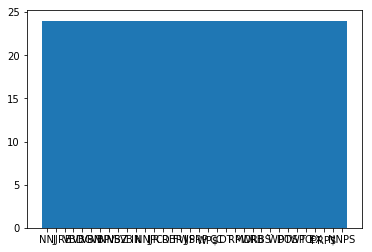

In [13]:
df = pos_df['POS'].values.tolist()
df1 = pd.Series(df).value_counts()
print(df1)
df1.reset_index()
df1.sort_values('index')
df1.reset_index(drop=True)
df1.index
fig, ax = plt.subplots(1, 1)
plt.axis('auto')
ax.bar(df1.index, df1['POS'], 1)

In [14]:
# print(raw_sentence_tokens[121:125])
# print(sentence_to_wordlist(raw_sentences[20]))
# print(sentences[1:500])

In [15]:
token_count = sum([len(sentence) for sentence in sentences])
# print("The book corpus contains {0:,} tokens.".format(token_count))

In [16]:
# Once we have vectors
# Step 3 - Build Model
# 3 main tasks that vectors help with
# DISTANCE, SIMILARITIES, RANKING

# Dimensionality of the resulting word vectors.
# More dimensions, more computationally expensive to train but also more accurate
# more dimensions = more generalized
num_features = 307

# Minimum word count threshold.
min_word_count = 100

# Number of threads to run in parallel.
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 17

# Downsample setting for frequent words.
# 0 - 1e-5 is good for this
downsampling = 1e-4

# Seed for the RNG, to make the results reproducible.
# random number generator
seed = 1

In [17]:
phys2vec = w2v.Word2Vec(
    sg = 1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
phys2vec.build_vocab(sentences)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 87276 words, keeping 7881 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 173861 words, keeping 11443 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 257095 words, keeping 14342 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 334058 words, keeping 15392 word types
INFO:gensim.models.word2vec:collected 16767 word types from a corpus of 424109 raw words and 48291 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=100 retains 809 unique words (4% of original 16767, drops 15958)
INFO:gensim.models.word2vec:effective_min_count=100 leaves 286684 word corpus (67% of original 424109, drops 137425)
INFO:gensim.models.w

In [19]:
print("Word2Vec vocubulary length:", len(phys2vec.wv.vocab))

Word2Vec vocubulary length: 809


In [20]:
phys2vec.train(sentences, total_examples=phys2vec.corpus_count, epochs = phys2vec.epochs)

INFO:gensim.models.base_any2vec:training model with 8 workers on 809 vocabulary and 307 features, using sg=1 hs=0 sample=0.0001 negative=5 window=17
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.base_any2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.base_any2vec:EPOCH - 1 : training on 424109 raw words (97273 effective words) took 0.3s, 345659 effective words/

(485402, 2120545)

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
phys2vec.save(os.path.join("trained", "phys2vec.w2v"))

INFO:gensim.utils:saving Word2Vec object under trained\phys2vec.w2v, separately None
INFO:gensim.utils:not storing attribute vectors_norm
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved trained\phys2vec.w2v


In [23]:
phys2vec = w2v.Word2Vec.load(os.path.join("trained", "phys2vec.w2v"))

INFO:gensim.utils:loading Word2Vec object from trained\phys2vec.w2v
INFO:gensim.utils:loading wv recursively from trained\phys2vec.w2v.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute vectors_norm to None
INFO:gensim.utils:loading vocabulary recursively from trained\phys2vec.w2v.vocabulary.* with mmap=None
INFO:gensim.utils:loading trainables recursively from trained\phys2vec.w2v.trainables.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded trained\phys2vec.w2v


In [24]:
# sriraj has a good video on how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = phys2vec.wv.syn0

C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).



In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [27]:
# plot word vectors in 2d space
points =  pd.DataFrame(
    [
        (word, coords[0], coords[1], freq)
        for word, coords, freq in [
            (word, all_word_vectors_matrix_2d[phys2vec.wv.vocab[word].index], phys2vec.wv.vocab[word].count)
            for word in phys2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y", "freq"]
)

                word          x          y  freq
304           charge -33.453125  -2.093282  4451
129         equation   6.170146  29.860346  4127
303         electric -33.408165  -1.246801  3134
305         magnetic -32.359280  -7.332518  2831
12              mass   7.315826  20.340261  2730
6             motion  19.435102  19.757181  2540
339        potential -11.720446  -6.110945  2371
142           vector  -3.319466  29.442095  2351
147             wave   6.923160 -19.255981  2203
146        direction -27.188337  -5.157423  2118
94          velocity   5.495637  19.610451  2117
1             physic  11.589417 -25.449333  2064
125         constant  11.195724   6.411398  2054
472      temperature  23.446020 -14.436418  2028
197         particle   0.042411   6.359428  1978
101       coordinate   8.742472  33.331146  1880
110          surface -29.267469   2.047028  1809
345             heat  26.355951 -10.854049  1693
492              sin -16.573402  24.774361  1653
650          circuit

<BarContainer object of 809 artists>

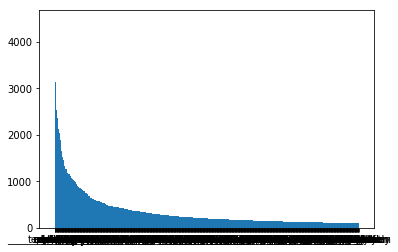

In [28]:
fig, ax = plt.subplots(1, 1)
points_sorted = points.sort_values('freq', ascending=False)
print(points_sorted)
ax.bar(points_sorted.word, points_sorted.freq, 1)

In [29]:
# freq = []
# for word in phys2vec.wv.vocab:
#     freq.append(phys2vec.wv.vocab[word].count)
# frequency = pd.DataFrame({"frequency" : freq})
# points = pd.concat([points, frequency], axis = 1)
# print(points.loc[points['word']=='atom'])

In [30]:
# # gravitational clustering
# max_coords = max(max(points.x), max(points.y))
# max_freq = max(points.freq)
# mass = points.freq/max_freq
# position = [points.x/max_coords, points.y/max_coords]
# velocity = [points.x/max_coords, points.y/max_coords]
# print(position)
# # print(position[0][0] - position[1][0])
# t = 0
# t_final = 1
# k = 0.000000618
# dt = 0.01
# for time in range(0, t_final):
#     t = t + dt
#     i = 0
#     for word_i in points.word:
#         j = 0
#         s_i_x = position[0][i]
#         s_i_y = position[1][i]
#         a_ji_x = 0
#         a_ji_y = 0
#         for word_j in points.word:
#             if word_i != word_j:
#                 a_num = k*mass[j]

#                 s_j_x = position[0][j]
#                 s_j_y = position[1][j]

#                 r_ij_x = s_j_x - s_i_x
#                 r_ij_y = s_j_y - s_i_y
#                 a_ji_x = a_ji_x + a_num/r_ij_x**2
#                 a_ji_y = a_ji_y + a_num/r_ij_y**2

#             j = j+1
            
#         position[0][i] = velocity[0][i]*dt + 0.5*a_ji_x*dt**2
#         position[1][i] = velocity[1][i]*dt + 0.5*a_ji_y*dt**2
        
#         velocity[0][i] = velocity[0][i] + a_ji_x*dt
#         velocity[1][i] = velocity[1][i] + a_ji_y*dt          
            
#         i = i + 1

# print(position)


In [31]:
# position = np.asarray(position)
# print(position)

In [32]:
# # new plot word vectors in 2d space
# new_points = pd.DataFrame(
#     {"word" : points.word,
#     "x" : position[0],
#     "y" : position[1],
#     "freq" : mass}
# )
# print(new_points)

In [33]:
sns.set_context("poster")

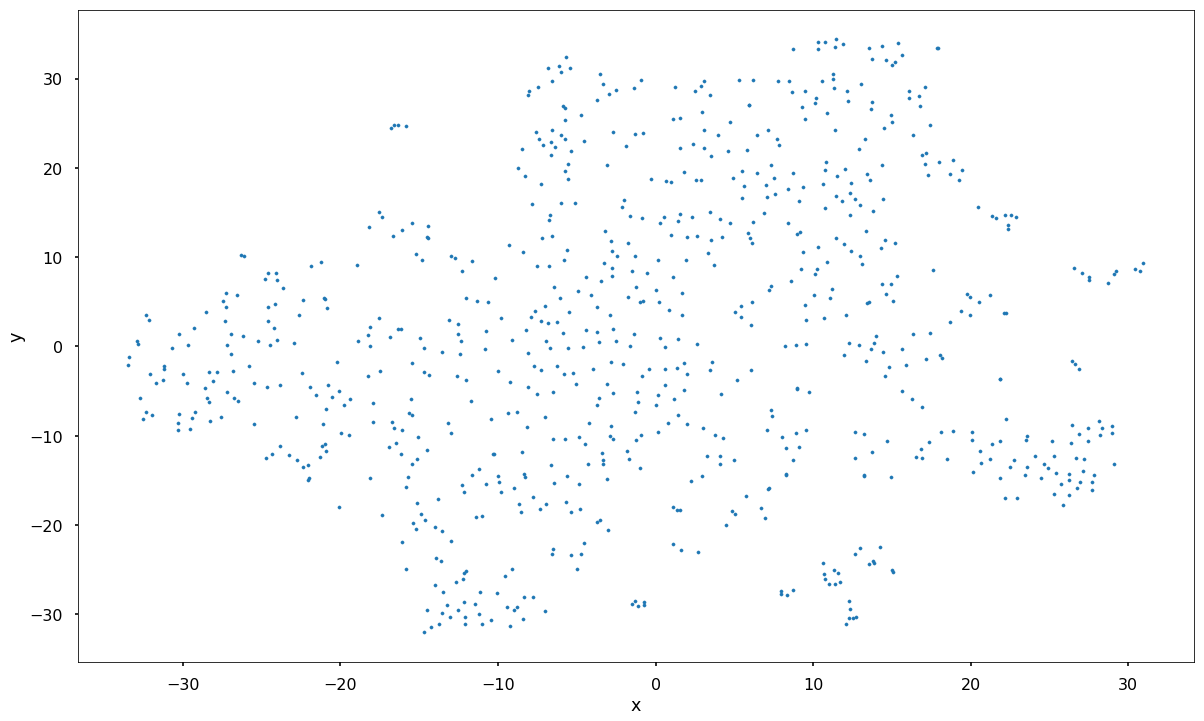

In [34]:
points.plot.scatter("x", "y", s=10, figsize = (20, 12))

In [35]:
#zoom in to some interesting places
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

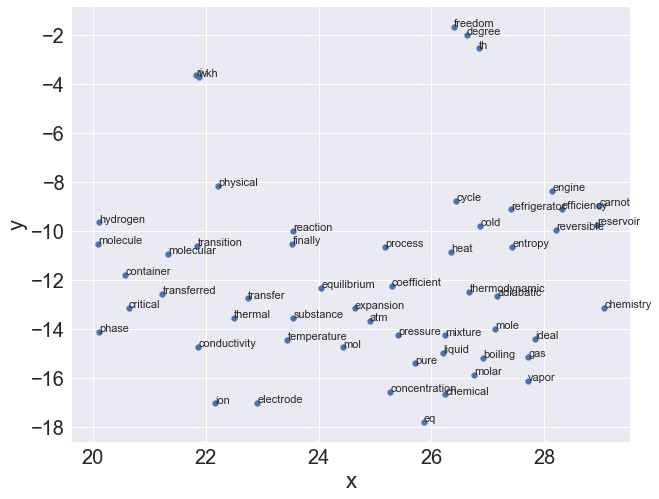

In [56]:
#particularly impressive region 2 - oscillation related terms
plot_region(x_bounds=(20, 30), y_bounds=(-20, 0))

In [37]:
# new_points.plot.scatter("x", "y", s=10, figsize = (20, 12))

In [38]:
# plt.plot(new_points.x, new_points.y, 'ro')
# plt.axis([-0.05, 0.05, -0.05, 0.05])

In [39]:
#particularly impressive region 3 - thermodynamic related terms
# plot_region(x_bounds=(-50, -20), y_bounds=(-10, 20))

In [40]:
#k means clustering experiment
X = phys2vec.wv[phys2vec.wv.vocab]

In [41]:
NUM_CLUSTERS=19
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=30)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (len(assigned_clusters))

809


In [42]:
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [43]:
#hierarchical hypothesis
def hierarchy(cluster_points):
# cluster_points = ['atom', 'proton', 'electron', 'molecule']
    word_counts = {}
    other_word_dict = {}
    relations = []
    other_word_count = 0
    terms = {}
    titles = {}
    disambiguated = []
    for word in cluster_points:
        try:
            word_wiki = wikipedia.WikipediaPage(title = word).content.lower()
#         except wikipedia.exceptions.DisambiguationError as e:
            for other_word in cluster_points:
                other_word_count = word_wiki.count(other_word)
                terms[other_word] = other_word_count
#                 if other_word_count > 2:
                relations.append((word, other_word))
            titles[word] = terms
            terms = {}
        
        except:
            disambiguated.append(word)
            print(word)
            
    for title in titles:
        for term in disambiguated:
            del titles[title][term]
    #                 for i, topic in enumerate(e.options):
    #                     print(i, topic)
    #                 choice = int(input("Enter a choice: "))
    #                 assert choice in range(len(e.options))
#             word_wiki = wikipedia.WikipediaPage(title = e.options[0]).content.lower()             
    return titles

In [44]:
#print cluster 11, 13, 18
#cluster_points = pd.concat([points.loc[labels==1], points.loc[labels==21], points.loc[labels==22]])
cluster_points = points.loc[labels==2]
print(points.loc[labels==2])

              word          x          y  freq
20       therefore  10.057378   5.751167  1136
22          recall -15.449169 -13.206940   118
45          length -17.924990  -8.437645  1078
47            flow  -4.509914 -10.900362   650
48           shift   2.659067   0.297221   184
76          answer -15.151565 -12.668653   469
77         remains   1.424723  -7.706005   138
87          signal   4.165016  -5.333012   235
88         instant -19.395790  -5.846506   101
98        consider   0.167327  -5.452982   902
99     represented   1.450365   0.773475   185
106       describe  -6.998454  -7.897387   268
116        suppose -13.524789  -0.669032   346
118      measuring  -4.870325 -10.208967   143
121        measure  -0.936315  -9.975272   431
123           zero -12.971855  10.113534  1077
128   relationship  -1.237875 -10.460151   170
130      according   0.172527  -9.569415   309
134          ratio  -3.325425 -13.152986   293
136    calculating -16.354897   1.918240   143
137        fo

In [47]:
titles = {}
terms = {}
for title in thermo_table:
    for term in thermo_table:
        terms[term] = thermo_table[term][title] - thermo_table[title][term]
    titles[title] = terms
    terms = {}
    
final_table = pd.DataFrame.from_dict({(i): titles[i]
                           for i in titles.keys() 
                           for j in titles[i].keys()},
                       orient='index')
final_table = final_table.sort_index(axis=1, ascending=True)

i = -1
j = -1
for title in final_table:
    i = i + 1
    for term in final_table[title]:
        j = j + 1
        if i < j:
            final_table[title][j] = 0
    j = -1
            
final_table
        

,amplitude,apply,approximately,arrow,attached,calculated,calculating,cause,caused,cross,...,solution,strategy,suppose,symbol,take,therefore,travel,vacuum,width,zero
amplitude,0,0,0,0,0,0,1,3,0,0,...,1,0,0,0,0,1,0,0,0,1
apply,0,0,0,0,0,0,0,1,-1,0,...,0,-1,0,0,3,0,0,-1,0,-2
approximately,0,0,0,0,0,0,0,3,0,0,...,7,0,0,4,0,0,0,0,0,0
arrow,0,0,0,0,6,0,0,-9,-15,2,...,0,0,0,0,2,0,2,-1,0,-1
attached,0,0,0,0,0,0,0,3,0,1,...,0,0,0,0,-1,0,0,0,0,0
calculated,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,-1
calculating,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-1,0,-1
cause,0,0,0,0,0,0,0,0,-201,5,...,-1,-3,-3,0,4,-2,3,-4,0,-7
caused,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,5,2,3,-1,0,0
cross,0,0,0,0,0,0,0,0,0,0,...,0,0,1,19,6,0,0,0,-1,0


<Figure size 1800x1800 with 0 Axes>

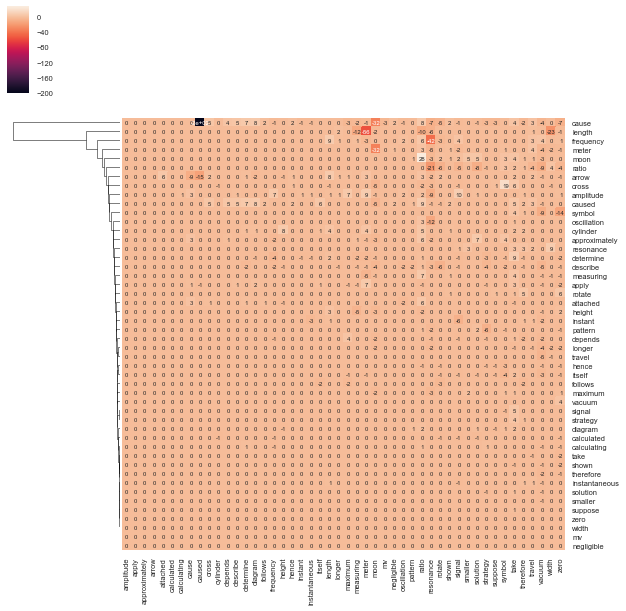

In [48]:
sns.set(font_scale=0.75)
# sns.set_context("poster")
plt.figure(figsize=(25, 25))
sns.clustermap(final_table, annot=True, linewidths=0, annot_kws={"size": 6}, col_cluster=False)

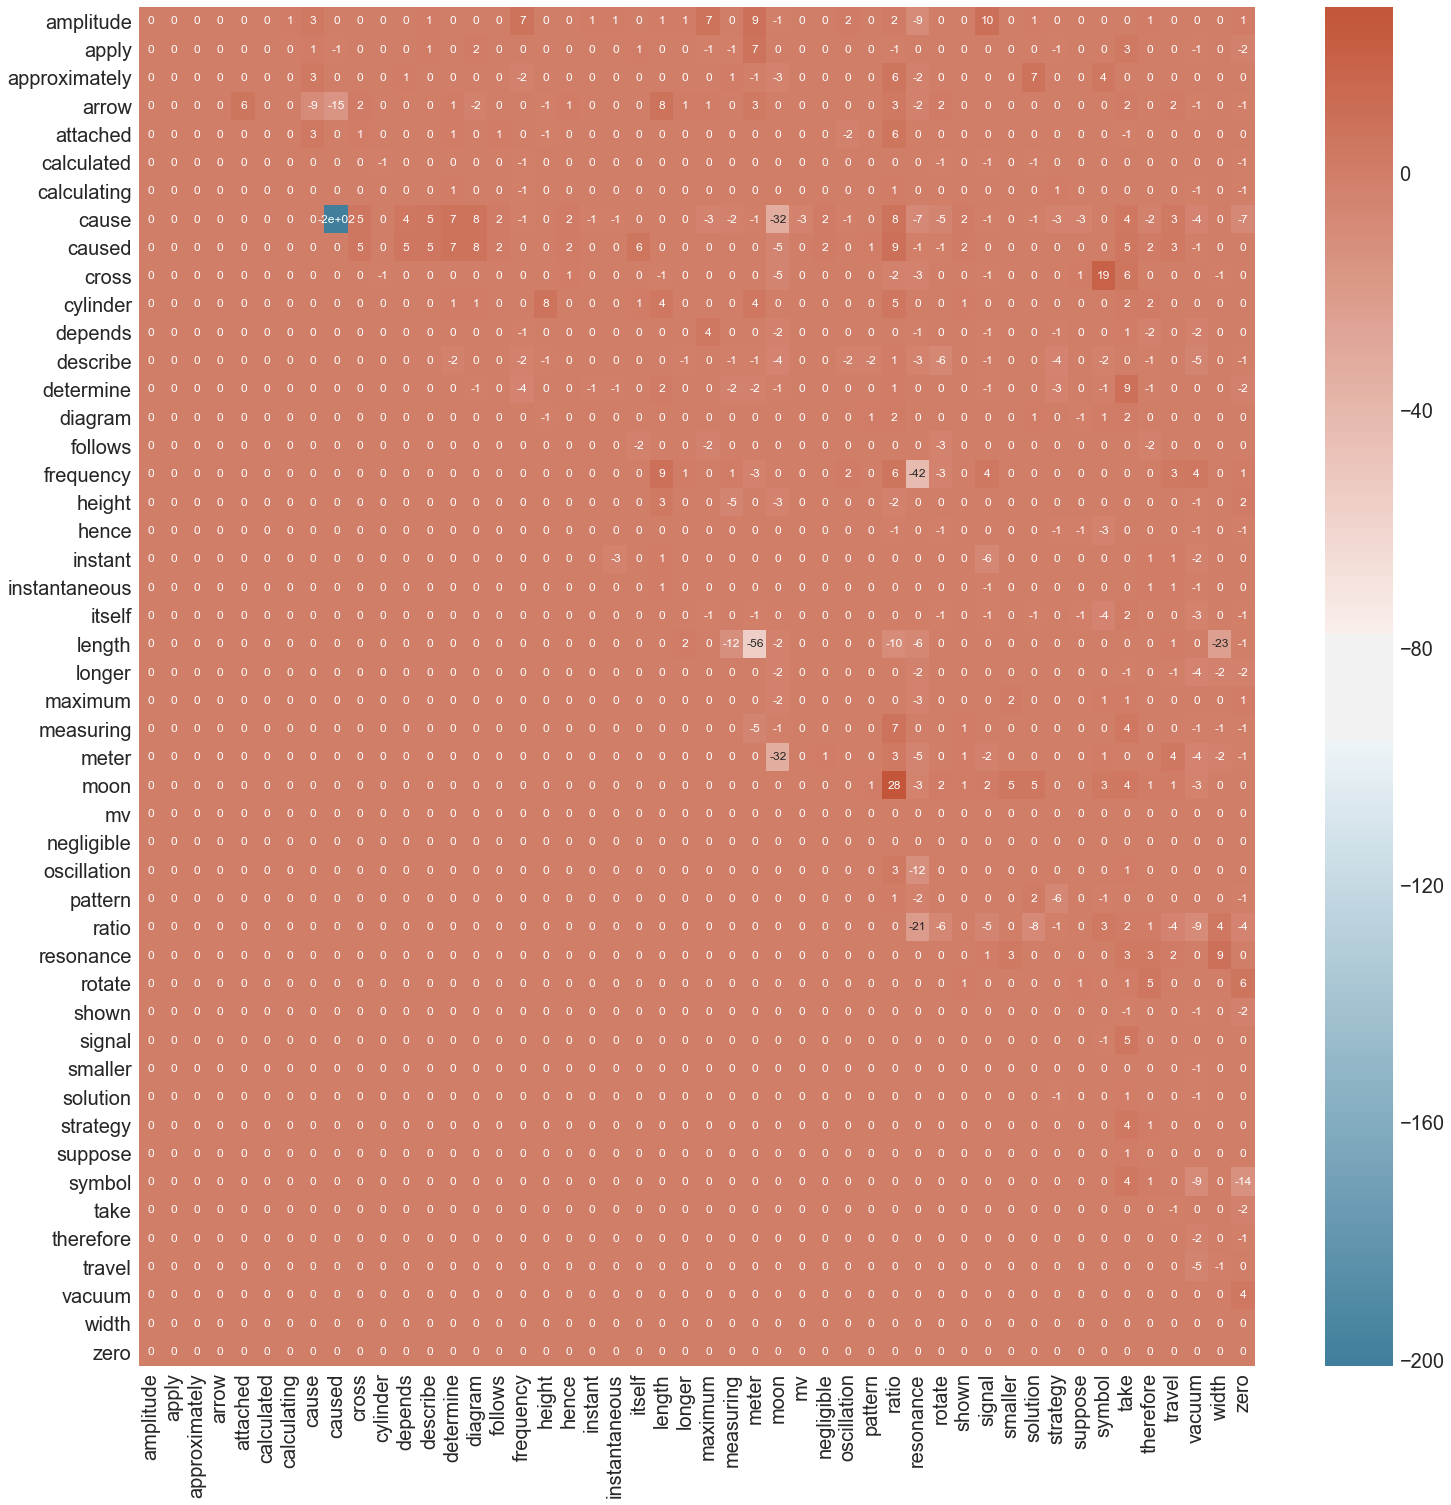

In [49]:
sns.set(font_scale=2)
# sns.set_context("poster")
plt.figure(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, sep=20, as_cmap=True)
sns.heatmap(final_table, annot=True, linewidths=0, annot_kws={"size": 12}, cmap=cmap)

In [50]:
import operator
final_table_trans = final_table
totals = {}
for title in final_table_trans:
    totals[title] = 0
    for term in final_table_trans[title]:
        totals[title] += term 
print(sorted(totals.items(), key=operator.itemgetter(1)))

[('caused', -217), ('resonance', -124), ('moon', -95), ('vacuum', -59), ('meter', -47), ('zero', -31), ('rotate', -23), ('measuring', -21), ('strategy', -20), ('width', -17), ('frequency', -5), ('instantaneous', -4), ('signal', -4), ('suppose', -4), ('mv', -3), ('cylinder', -2), ('instant', -1), ('oscillation', -1), ('amplitude', 0), ('apply', 0), ('approximately', 0), ('arrow', 0), ('calculated', 0), ('calculating', 1), ('cause', 1), ('pattern', 1), ('height', 4), ('longer', 4), ('follows', 5), ('maximum', 5), ('negligible', 5), ('solution', 5), ('attached', 6), ('hence', 6), ('itself', 6), ('shown', 9), ('depends', 10), ('smaller', 10), ('therefore', 11), ('describe', 12), ('cross', 13), ('travel', 15), ('determine', 16), ('diagram', 16), ('symbol', 20), ('length', 28), ('take', 64), ('ratio', 76)]


In [51]:
#poincare embedding
model = PoincareModel(train_data=relations, size=2, burn_in=0)
model.train(epochs=200, print_every=500)
iplot(poincare_2d_visualization(model, relations, figure_title = "wohoo", show_node_labels=node_labels))

INFO:gensim.models.poincare:loading relations from train data..


ValueError: Relation pair "'therefore'" should have exactly two items

In [ ]:
# mpld3.enable_notebook()
# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(cluster_points["x"], cluster_points["y"], cluster_points["freq"], c='r', marker='o')

In [52]:
phys2vec.wv.most_similar("pendulum")

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors
C:\Users\Karan\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



[('linear', 0.9398318529129028),
 ('wheel', 0.9363640546798706),
 ('spring', 0.9362322092056274),
 ('harmonic', 0.9352393746376038),
 ('rotational', 0.9229419231414795),
 ('oscillator', 0.9160948395729065),
 ('damped', 0.9149628281593323),
 ('motion', 0.9148856997489929),
 ('periodic', 0.9118204116821289),
 ('linearly', 0.9067602157592773)]

In [53]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = phys2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [54]:
nearest_similarity_cosmul("electron", "proton", "positive")
nearest_similarity_cosmul("proton", "positive", "negative")
nearest_similarity_cosmul("acceleration", "force", "momentum")
nearest_similarity_cosmul("electricity", "charge", "magnetic")
nearest_similarity_cosmul("photon", "einstein", "newton")
nearest_similarity_cosmul("voltage", "current", "electron")

electron is related to proton, as conducting is related to positive
proton is related to positive, as neutron is related to negative
acceleration is related to force, as angular is related to momentum
electricity is related to charge, as magnetism is related to magnetic
photon is related to einstein, as moon is related to newton
voltage is related to current, as decrease is related to electron


C:\Users\Karan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).



'decrease'